In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

O dataset traz um código que ja divide as imagens em 80% treino, 10% validação e 10% teste então eu não fiz train_tes_split. Só direcionei os diretórios. 

In [3]:
# Definir diretórios dos conjuntos de imagens
train_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\train"
val_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\val"
test_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\test"

**`img_size`** : Define o tamanho de cada imagem que será alimentada ao modelo. Como o modelo de CNN está criando está lidando com imagens, é necessário garantir que todas as imagens sejam redimensionadas para um tamanho comum antes de serem passadas para a rede.  
**OBS:** A escolha de 128x128 é um equilíbrio comum entre qualidade da imagem e exigência de recursos computacionais. Imagens maiores poderiam proporcionar mais detalhes, mas também aumentariam o custo computacional e o tempo de treinamento. Imagens menores, por outro lado, podem perder informações importantes.  

**`batch_size`** : Define o número de imagens que serão passadas pela rede neural em uma única iteração durante o treinamento.  
**OBS:** Um batch grande (ex: 64, 128, 256) pode acelerar o treinamento e melhorar a estabilidade da estimativa do gradiente, mas exigirá mais memória e pode tornar o modelo mais propenso a ficar preso em mínimos locais (menor diversidade nos gradientes); já um batch pequeno (ex: 16, 8, 4) pode tornar o treinamento mais ruidoso (maior variabilidade nos gradientes), mas muitas vezes melhora a generalização e pode ser mais adequado se a memória for limitada.

In [6]:
# Parâmetros
img_size = (128, 128)
batch_size = 32

As imagens geralmente têm valores de pixel entre 0 e 255 (para imagens em RGB). No entanto, as redes neurais geralmente funcionam melhor quando os valores dos pixels estão em uma faixa menor, como [0, 1] em vez de [0, 255].
Para isso, o parâmetro rescale=1.0 / 255.0 é utilizado. Ele divide os valores dos pixels por 255, o que transforma os valores de pixel de uma faixa de [0, 255] para uma faixa de [0, 1].

**OBS:** A normalização ajuda a acelerar o processo de treinamento, pois pode reduzir a variabilidade nos gradientes e melhorar a convergência. Também pode ajudar o modelo a se ajustar de maneira mais eficiente aos dados.

In [9]:
# Pré-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

**`train_datagen:`** Este é o objeto de pré-processamento que foi configurado anteriormente (com a normalização dos pixels e, possivelmente, aumentos de dados, caso tenha sido configurado).  

**`flow_from_directory(train_dir):`** Este método cria um gerador que irá buscar as imagens no diretório train_dir (diretório que contém as imagens de treinamento). As imagens devem estar organizadas em subpastas, onde cada subpasta representa uma classe. O nome da subpasta será usado como o rótulo da classe.  

**`target_size=img_size:`** Redimensiona todas as imagens para o tamanho especificado (no seu caso, 128x128). Isso é importante porque a rede neural precisa de entradas de tamanho fixo.  

**`batch_size=batch_size:`** Define o número de imagens a serem processadas em cada lote (batch) durante o treinamento. Aqui, foi definido como 32, ou seja, 32 imagens serão carregadas em cada iteração.  

**`class_mode="categorical":`** Como você está tratando um problema de classificação multiclasse, este parâmetro indica que as labels (rótulos) serão codificadas de forma categórica. Ou seja, para cada imagem, a saída será um vetor "one-hot" representando a classe da imagem.

In [12]:
# Criar os geradores de dados (Treino, Teste e Validação)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

Found 25321 images belonging to 1000 classes.
Found 4541 images belonging to 1000 classes.
Found 6022 images belonging to 1000 classes.


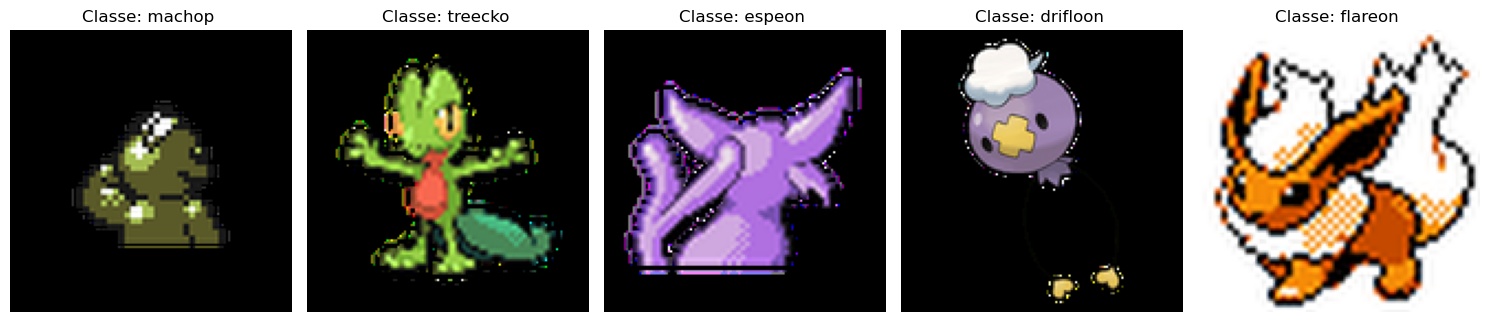

In [13]:
# Visualizar 5 exemplos do conjunto de treino
class_names = list(train_generator.class_indices.keys())
num_examples = 5

fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
train_images, train_labels = next(train_generator)

for i in range(num_examples):
    img = train_images[i]
    axes[i].imshow(img)
    axes[i].set_title(f"Classe: {class_names[np.argmax(train_labels[i])]} ")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

O Keras não possui uma métrica nativa de F1-Score, e por isso a solução mais comum é criar uma métrica personalizada para computá-la a partir das métricas básicas de precisão e recall. Segue a idéia:

A classe F1Score herda de tf.keras.metrics.Metric, o que permite criar métricas personalizadas para serem usadas com o TensorFlow/Keras.  
Definimos duas métricas auxiliares: Precision e Recall (essas duas métricas serão usadas para calcular o F1-Score.)  

Lembrando que `precision` mede a proporção de predições positivas corretas, e `recall` mede a proporção de instâncias positivas que foram corretamente identificadas, ou seja, quantas das instâncias reais positivas foram capturadas pelo modelo.  

**`name="f1_score":`** Esse é o nome da métrica personalizada que será exibido durante o treinamento e avaliação.  

**`super(F1Score, self).__init__(name=name, kwargs):`** Chama o inicializador da classe pai Metric para garantir que a classe personalizada seja registrada corretamente no TensorFlow/Keras.

In [18]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

O próximo método é chamado durante o treinamento e a avaliação do modelo para atualizar o estado da métrica.  
Ele recebe os valores verdadeiros (y_true) e preditos (y_pred), e, se necessário, os pesos amostrais (sample_weight). De modo que:

**`self.precision.update_state(y_true, y_pred, sample_weight):`** Atualiza o cálculo da precisão com base nos valores verdadeiros e preditos.
**`self.recall.update_state(y_true, y_pred, sample_weight):`** Atualiza o cálculo do recall com base nos valores verdadeiros e preditos.

In [21]:
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

Este método é chamado para calcular o valor da métrica (o F1-Score). Ele retorna o valor final da métrica com base nos valores de precisão e recall que foram atualizados. (A fórmula é uma média harmônica entre a precisão e o recall).

**OBS:** O professor pode perguntar sobre esse epsilon `tf.keras.backend.epsilon()` -  ele é um pequeno valor constante (tipicamente 
1×10^(-7)) que é somado no denominador para evitar divisão por zero, caso precision + recall seja muito pequeno ou zero.

In [25]:
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

O próximo método é chamado para resetar o estado das métricas de precisão e recall. Isso é necessário entre as épocas de treinamento ou quando você deseja limpar as estatísticas internas para um novo cálculo.

In [28]:
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

**OBS:** Aqui é a CNN (Pode por no chatGPT para entender melhor o funcionamento dela)

Found 25321 images belonging to 1000 classes.
Found 4541 images belonging to 1000 classes.
Found 6022 images belonging to 1000 classes.


C:\Users\Davys\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │       257,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,773,032 (25.84 MB)

 Trainable params: 6,773,032 (25.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


C:\Users\Davys\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


792/792 ━━━━━━━━━━━━━━━━━━━━ 127s 158ms/step - accuracy: 0.0058 - f1_score: 1.6903e-04 - loss: 6.7523 - precision: 0.1476 - recall: 8.4576e-05 - val_accuracy: 0.1412 - val_f1_score: 0.0295 - val_loss: 5.1601 - val_precision: 0.9067 - val_recall: 0.0150
Epoch 2/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 125s 157ms/step - accuracy: 0.1257 - f1_score: 0.0629 - loss: 5.0976 - precision: 0.7738 - recall: 0.0330 - val_accuracy: 0.5789 - val_f1_score: 0.4289 - val_loss: 2.4958 - val_precision: 0.9904 - val_recall: 0.2737
Epoch 3/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 124s 157ms/step - accuracy: 0.3857 - f1_score: 0.3713 - loss: 3.0802 - precision: 0.8394 - recall: 0.2388 - val_accuracy: 0.8269 - val_f1_score: 0.7520 - val_loss: 1.1678 - val_precision: 0.9978 - val_recall: 0.6034
Epoch 4/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 125s 158ms/step - accuracy: 0.5878 - f1_score: 0.6021 - loss: 1.8946 - precision: 0.8755 - recall: 0.4591 - val_accuracy: 0.9073 - val_f1_score: 0.8939 - val_loss: 0.5850 - val_precision: 0.9962 

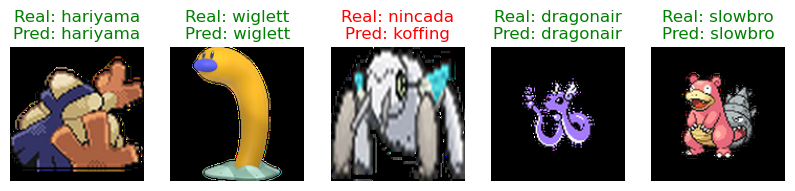

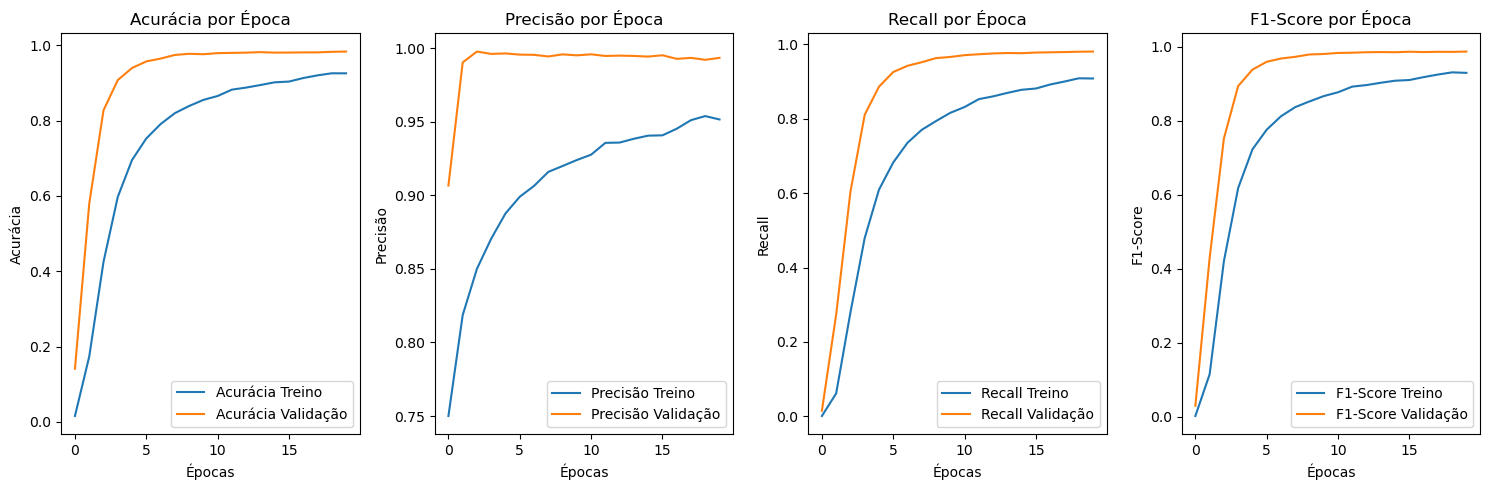

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Explicação do problema
# O objetivo deste modelo é classificar imagens de Pokémon utilizando uma Rede Neural Convolucional (CNN).
# O dataset contém múltiplas classes, cada uma representando um Pokémon diferente. O modelo será treinado,
# avaliado e testado para prever corretamente qual Pokémon está presente em cada imagem.

# Definir diretórios dos conjuntos de imagens
train_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\train"
val_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\val"
test_dir = r"C:\Users\Davys\Downloads\PPCE\Pokedex-Leonan\test"

# Parâmetros
img_size = (128, 128)
batch_size = 32

# Pré-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Criar os geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Definir a métrica F1 personalizada
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Criar a CNN
model = Sequential([  
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Exibir arquitetura do modelo
model.summary()

# Compilar o modelo com as métricas de precisão, recall e F1Score
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

# Função para coletar as métricas durante o treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

# Avaliar o modelo no conjunto de teste
loss, accuracy, precision, recall, f1_score_value = model.evaluate(test_generator)
print(f'Loss no teste: {loss:.4f}, Acurácia no teste: {accuracy:.4f}, Precisão no teste: {precision:.4f}, Recall no teste: {recall:.4f}, F1-Score no teste: {f1_score_value:.4f}')

# Mostrar algumas imagens de teste com rótulos reais e preditos
class_names = list(train_generator.class_indices.keys())
images, labels = next(test_generator)
predictions = model.predict(images)
pred_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[pred_labels[i]]
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Real: {true_label}\nPred: {predicted_label}", color=color)
    axes[i].axis("off")
plt.show()

# Plotar as curvas das métricas
plt.figure(figsize=(15, 5))

# Acurácia
plt.subplot(1, 4, 1)
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia por Época')

# Precisão
plt.subplot(1, 4, 2)
plt.plot(history.history['precision'], label='Precisão Treino')
plt.plot(history.history['val_precision'], label='Precisão Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão por Época')

# Recall
plt.subplot(1, 4, 3)
plt.plot(history.history['recall'], label='Recall Treino')
plt.plot(history.history['val_recall'], label='Recall Validação')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall por Época')

# F1-Score
plt.subplot(1, 4, 4)
plt.plot(history.history['f1_score'], label='F1-Score Treino')
plt.plot(history.history['val_f1_score'], label='F1-Score Validação')
plt.xlabel('Épocas')
plt.ylabel('F1-Score')
plt.legend()
plt.title('F1-Score por Época')

plt.tight_layout()
plt.show()